# MazeRunner

---

This notebook covers basic search algorithms for **Path-Finding in a Maze**.       

You will see *uninformed search* algorithms like `breadth_first_search`, `depth_first_search` and `uniform_cost_search`, as well as *informed search* algorithms like `greedy_search` and `astar_search` in action. The setup is a maze with the problem of finding an escape path from the *start* position to the *goal* position on a two-dimensional grid. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue

### Helper functions for the Maze

These are just a few helper functions for you to work with the maze/grid easily, and to visualize them in a nice way. **No need to edit in general.**

In [3]:
# Helper functions to work with the Maze

def printBinaryMaze(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Simple print of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    
    print()
    for i in range(height):
        for j in range(width):
            if mazeGrid[i,j] == 1:
                print("\u25a9", end = " ")   # use some other character if the unicode does not print properly
            elif mazeGrid[i,j] == 0:
                print(".", end = " ")
        print()
        

def showBinaryMaze(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Heatmap grid of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Greys", cbar = False)
    
    
def showBinaryMazeProblem(mazeGrid, start, goal):
    ''' Display the maze corresponding to a binary grid
        Display "start" and "goal" position on the grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinate of the "start" and "goal"
        Output : Heatmap grid of the maze with markers
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255
    
    mazeGrid[start[0], start[1]] = 128
    mazeGrid[goal[0], goal[1]] = 128
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Greys", cbar = False)

---
## Create the Maze as a 2D Grid

Let us create the maze as a standard two-dimensional grid, with reachable (blank) and unreachable (blocked) positions.

In [4]:
# Create the Maze
# 0 : empty cell, reachable within a path
# 1 : blocked cell or wall, not reachable

maze = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


# Convert to a NumPy array
maze = np.array(maze)

# Print the maze using helper functions
print("Maze of dimensions", maze.shape)
printBinaryMaze(maze)

Maze of dimensions (10, 20)

▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ 
▩ . . . ▩ . . . . . . . . . . . . . . ▩ 
▩ . ▩ . ▩ . . . . ▩ . ▩ . ▩ ▩ ▩ ▩ ▩ . ▩ 
▩ . ▩ . ▩ . ▩ ▩ . ▩ . ▩ . . ▩ . . . . ▩ 
▩ . ▩ . . . . ▩ . ▩ . . . . ▩ ▩ ▩ ▩ ▩ ▩ 
▩ . ▩ ▩ ▩ ▩ . ▩ . ▩ . ▩ ▩ . ▩ . . . . . 
▩ . . . . . . ▩ . ▩ . . ▩ . ▩ . ▩ ▩ ▩ ▩ 
▩ . ▩ ▩ ▩ ▩ ▩ ▩ . ▩ ▩ . ▩ ▩ ▩ . . . . ▩ 
▩ . . . . . . . . . ▩ . . . . . . . . ▩ 
▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ 


Display the maze as a Seaborn grayscale heatmap to clearly visualize the pattern and identify the underlying coordinates.

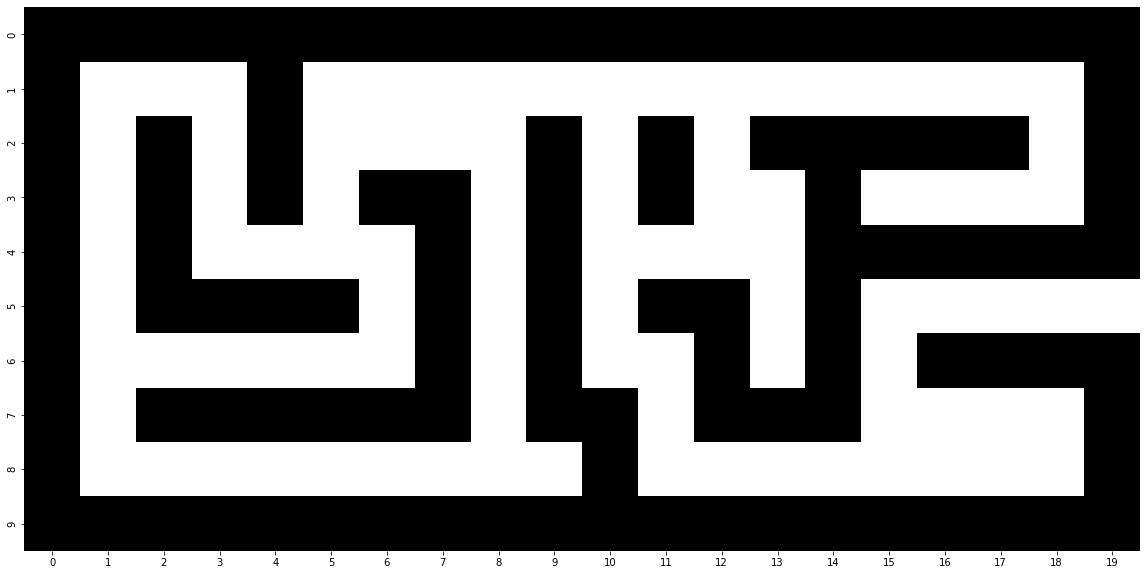

In [5]:
# Show the maze using helper functions
showBinaryMaze(maze)

---
## Path-finding Problem in the Maze

Define the path-finding problem on the maze created above by assigning the *START* and *GOAL* positions as coordinates.

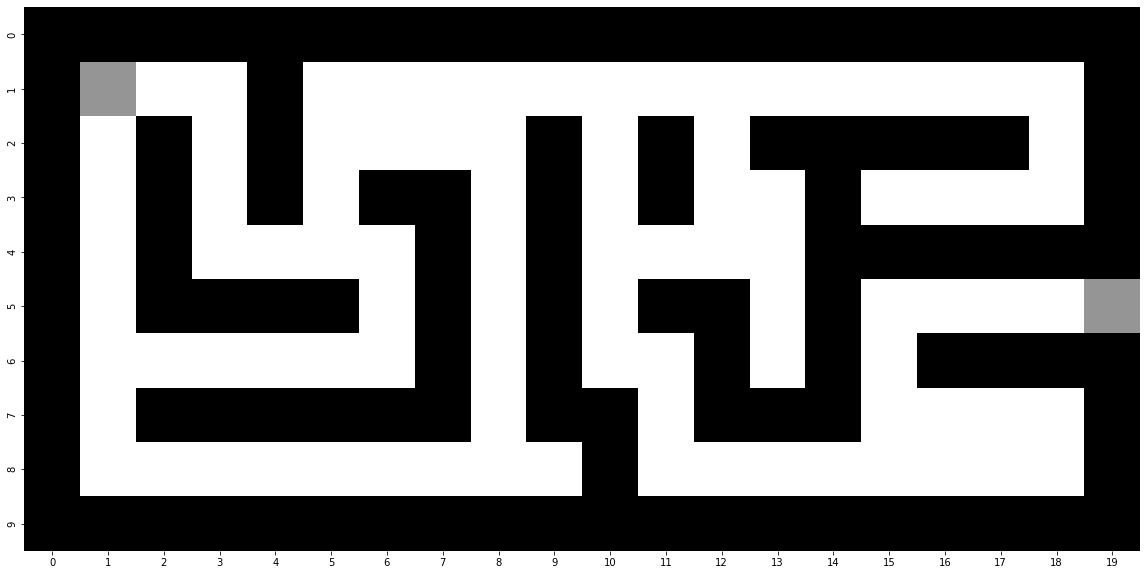

In [6]:
# Define start and goal positions
START = (1,1)
GOAL = (5,19)

# Show the maze using helper functions
showBinaryMazeProblem(maze, START, GOAL)

---
## Extract Graph from the Maze

In order to solve the path-finding problem, we will first extract the *traversal graph* corresponding to the maze. To start with, let's define `MazeGraph`.

In [7]:
# Create a Graph class
class MazeGraph(object):
    ''' Class to represent a Graph
        Construction : Using Edges
    '''
    def __init__(self):
        self.edges = {}
    
    def all_edges(self):
        return self.edges
    
    def neighbors(self, node):
        return self.edges[node]    

### Converting a Maze to a Graph

- The nodes/vertices in the graph are all the blank positions/cells in the maze     
- The blocked positions/cells in the maze are not considered as nodes/vertices
- Each node/vertex is connected to its adjacent blank positions/cells in the maze    
- Each node/vertex is assumed to have 4 adjacent nodes: Top, Left, Bottom, Right     
- Default weight for each such edge in the graph between two adjacent vertices is 1     
- We are assuming that diagonal traversal from one cell to another is not permitted    

In [8]:
# Function to convert a maze to a graph
def maze_to_graph(mazeGrid):
    ''' Converts a 2D binary maze to corresponding graph
        Input : 2D NumPy array with 0 and 1 as elements
        Output : MazeGraph corresponding to input maze
    '''
    mazeGraph = MazeGraph()
    (height, width) = mazeGrid.shape
    
    for i in range(height):
        for j in range(width):
            
            # Only consider blank cells as nodes
            if mazeGrid[i,j] == 0:
                
                neighbors = []
                
                # Adjacent cell : Top
                if (i > 0) and mazeGrid[i-1,j] == 0:
                    neighbors.append(((i-1,j), 1))
                    
                # Adjacent cell : Left                
                if (j > 0) and mazeGrid[i,j-1] == 0:
                    neighbors.append(((i,j-1), 1))
                    
                # Adjacent cell : Bottom                    
                if (i < height - 1) and mazeGrid[i+1,j] == 0:
                    neighbors.append(((i+1,j), 1))

                # Adjacent cell : Right                    
                if (j < width - 1) and mazeGrid[i,j+1] == 0:
                    neighbors.append(((i,j+1), 1))

                # Insert edges in the graph
                if len(neighbors) > 0:
                    mazeGraph.edges[(i,j)] = neighbors

    return mazeGraph

In [9]:
# Convert the maze to a graph
mazegraph = maze_to_graph(maze)

# Print the edges with weights
mazegraph.all_edges()

{(1, 1): [((2, 1), 1), ((1, 2), 1)],
 (1, 2): [((1, 1), 1), ((1, 3), 1)],
 (1, 3): [((1, 2), 1), ((2, 3), 1)],
 (1, 5): [((2, 5), 1), ((1, 6), 1)],
 (1, 6): [((1, 5), 1), ((2, 6), 1), ((1, 7), 1)],
 (1, 7): [((1, 6), 1), ((2, 7), 1), ((1, 8), 1)],
 (1, 8): [((1, 7), 1), ((2, 8), 1), ((1, 9), 1)],
 (1, 9): [((1, 8), 1), ((1, 10), 1)],
 (1, 10): [((1, 9), 1), ((2, 10), 1), ((1, 11), 1)],
 (1, 11): [((1, 10), 1), ((1, 12), 1)],
 (1, 12): [((1, 11), 1), ((2, 12), 1), ((1, 13), 1)],
 (1, 13): [((1, 12), 1), ((1, 14), 1)],
 (1, 14): [((1, 13), 1), ((1, 15), 1)],
 (1, 15): [((1, 14), 1), ((1, 16), 1)],
 (1, 16): [((1, 15), 1), ((1, 17), 1)],
 (1, 17): [((1, 16), 1), ((1, 18), 1)],
 (1, 18): [((1, 17), 1), ((2, 18), 1)],
 (2, 1): [((1, 1), 1), ((3, 1), 1)],
 (2, 3): [((1, 3), 1), ((3, 3), 1)],
 (2, 5): [((1, 5), 1), ((3, 5), 1), ((2, 6), 1)],
 (2, 6): [((1, 6), 1), ((2, 5), 1), ((2, 7), 1)],
 (2, 7): [((1, 7), 1), ((2, 6), 1), ((2, 8), 1)],
 (2, 8): [((1, 8), 1), ((2, 7), 1), ((3, 8), 1)],
 (2

### Displaying the Maze Graph

**This is optional.** Just a helper function to display the graph using NetworkX. You may examine the graph node-by-node is you wish.

In [10]:
# Helper functions to display a Graph

def showBinaryMazeGraph(mazeGraph):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []
    for node in edgeDict:
        for neighbor, weight in edgeDict[node]:
            edgeList.append((node,neighbor, {'weight': weight}))

    G = nx.Graph()
    G.add_edges_from(edgeList)

    f = plt.figure(figsize = (40,40))
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size = 2000)
    nx.draw_networkx_edges(G, pos, width = 2)
    nx.draw_networkx_labels(G, pos, font_size = 10)

    plt.axis("off")
    plt.show()

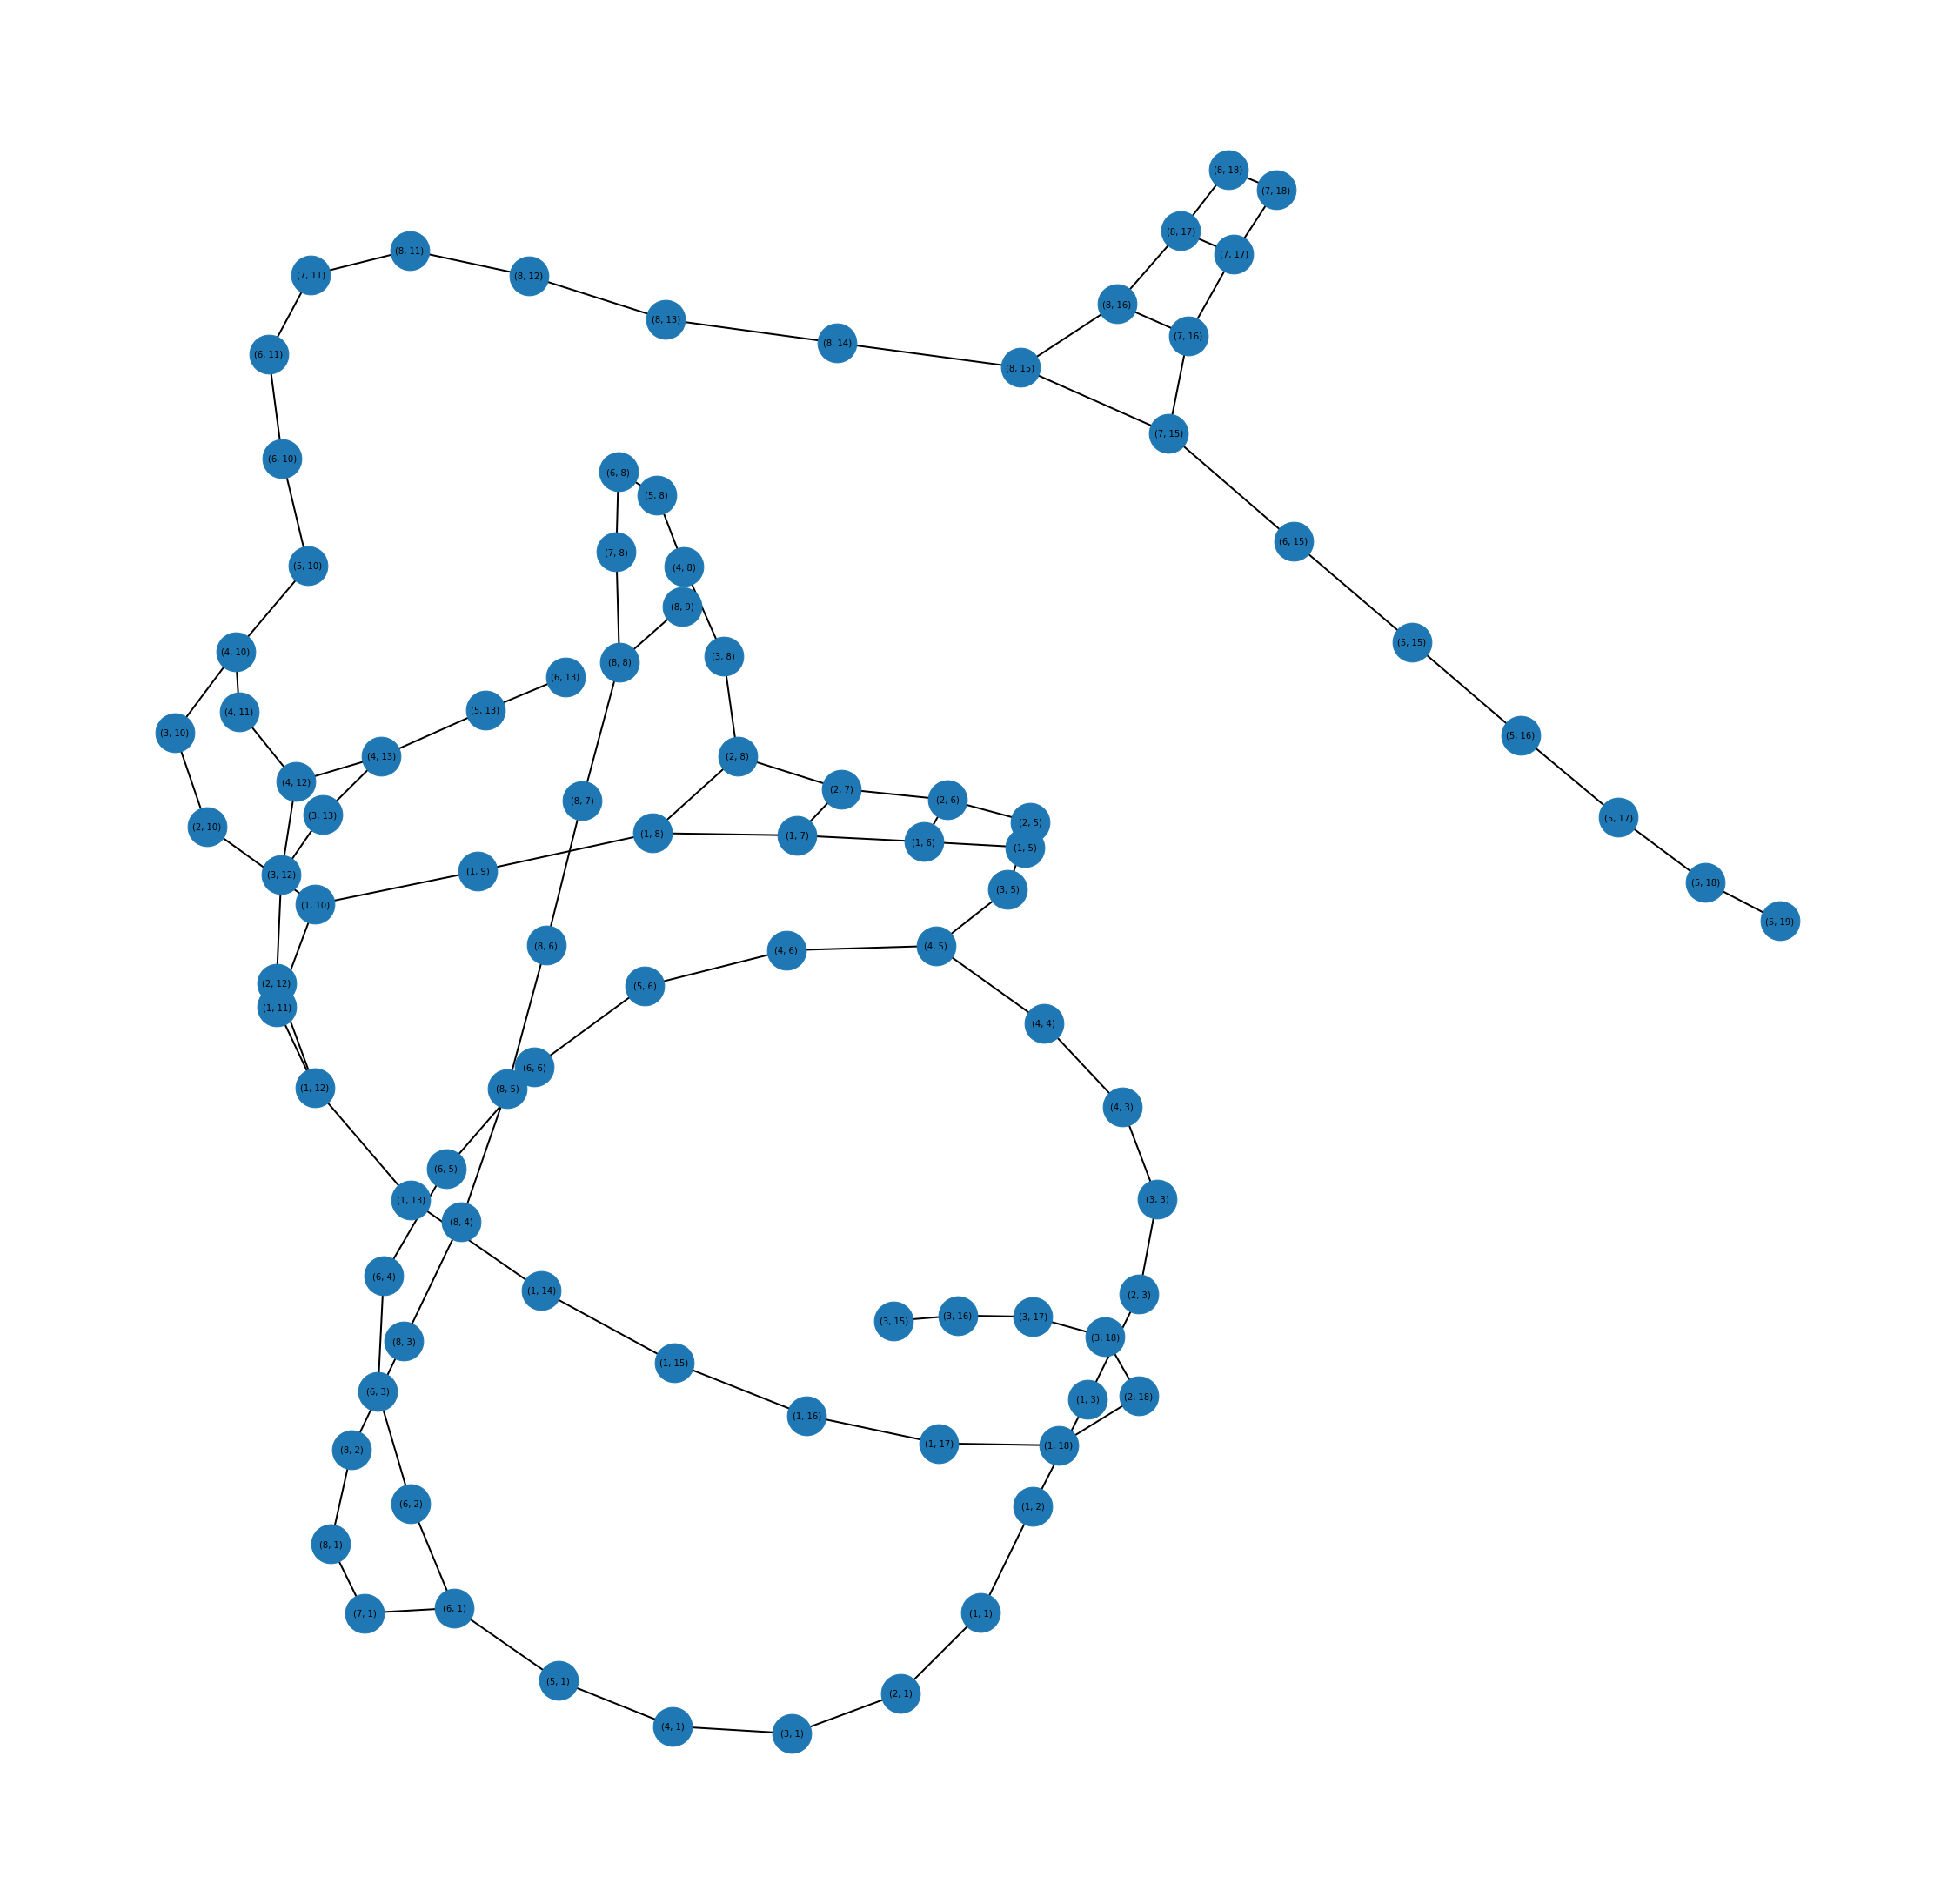

In [11]:
# Show the graph using helper functions
# The layout may change every time you run this cell
# However, the graph (nodes, edges) remains the same

showBinaryMazeGraph(mazegraph)

---
## Path Finding on the Graph

Now that we have the *traversal graph* corresponding to the maze, we may try out various path-finding search algorithms on the graph.

In [12]:
# Helper functions to work with the Maze with Path

def showBinaryMazePath(mazeGrid, mazePath):
    ''' Display the maze corresponding to a binary grid
        Display path(s) superimposed on the binary grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinates of the paths on the maze
        Output : Heatmap grid of the maze with the path
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    for node in mazePath:
        mazeGrid[node[0], node[1]] = 128     # half level of grayscale (0 to 255) to highlight the path
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Greys", cbar = False)

### Breadth-First-Search (BFS)

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [13]:
# Breadth-First-Search (BFS) with FIFO Queue

def breadth_first_search(mazeGraph, start, goal):
    ''' Function to perform BFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.Queue()    # FIFO Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
           
            # ignore if it has already been explored
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.put(nextNode)
                
                # assign current node as parent
                explored[nextNode] = currentNode
    
    return explored, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

Breadth-First-Search (BFS)

Total nodes in maze : 92
Total nodes visited : 92  |  100.0 %
Final path distance : 35

Path through the Maze : [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (6, 11), (7, 11), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (7, 15), (6, 15), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19)]


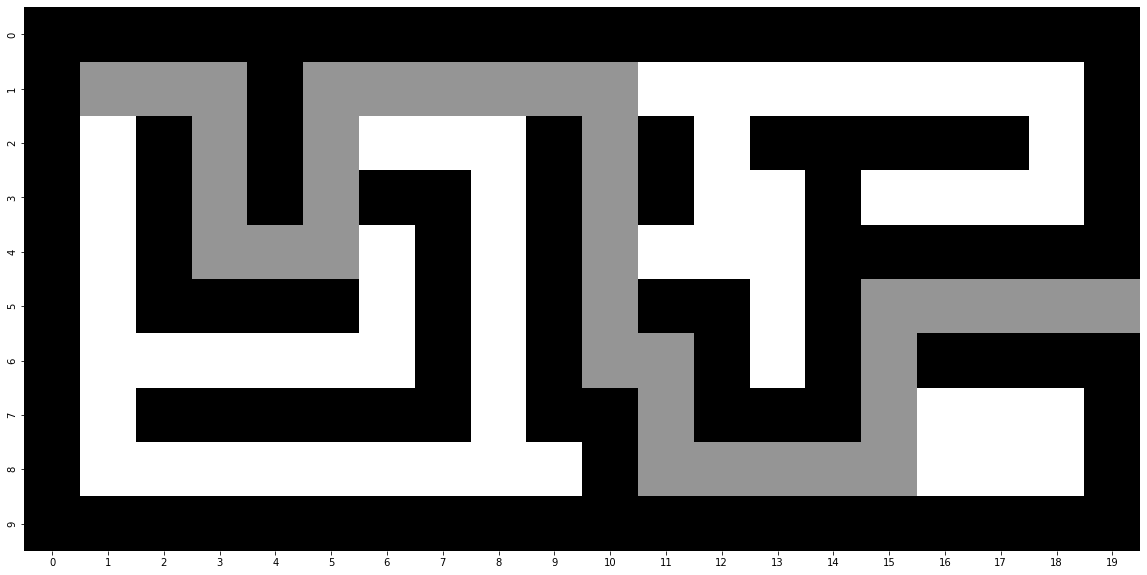

In [14]:
# Define start and goal positions
START = (1,1)
GOAL = (5,19)

# Run the BFS algorithm for path finding
nodesExplored, nodesProcessed = breadth_first_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
print("Breadth-First-Search (BFS)")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)

**Think about it!**

Is this algorithm *complete*? Is it *optimal*? What can you do to increase its *efficiency*?

It is complete as it is able to find a solution when it exists. It is optimal if all step costs are equal. To make it more efficient, we use heuristic to cut the search space.

### Depth-First-Search (DFS)

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [17]:
# This cell has MISSING pieces of code -- fill those in!

# Depth-First-Search (DFS) with _??_ Queue

def depth_first_search(mazeGraph, start, goal):
    ''' Function to perform DFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.LifoQueue()      # _LastInFirstOut_ Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        #current node = next node from frontier
        currentNode = frontier.get()
        processed += 1
        
        #stop when goal is reached
        if currentNode == goal:
            break
            
        #exploreevery single neighbour of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
            
            #ignore if it has already been explored
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.put(nextNode)
                
                #assign current node as parent
                explored[nextNode] = currentNode
                
        # Write the entire logic for this search algorithm
        # Hint : Take note from the BFS algorithm presented above
    
    return explored, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

Depth-First-Search (DFS)

Total nodes in maze : 92
Total nodes visited : 85  |  92.39 %
Final path distance : 57

Path through the Maze : [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (2, 8), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 12), (3, 12), (4, 12), (4, 11), (4, 10), (5, 10), (6, 10), (6, 11), (7, 11), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (7, 15), (6, 15), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19)]


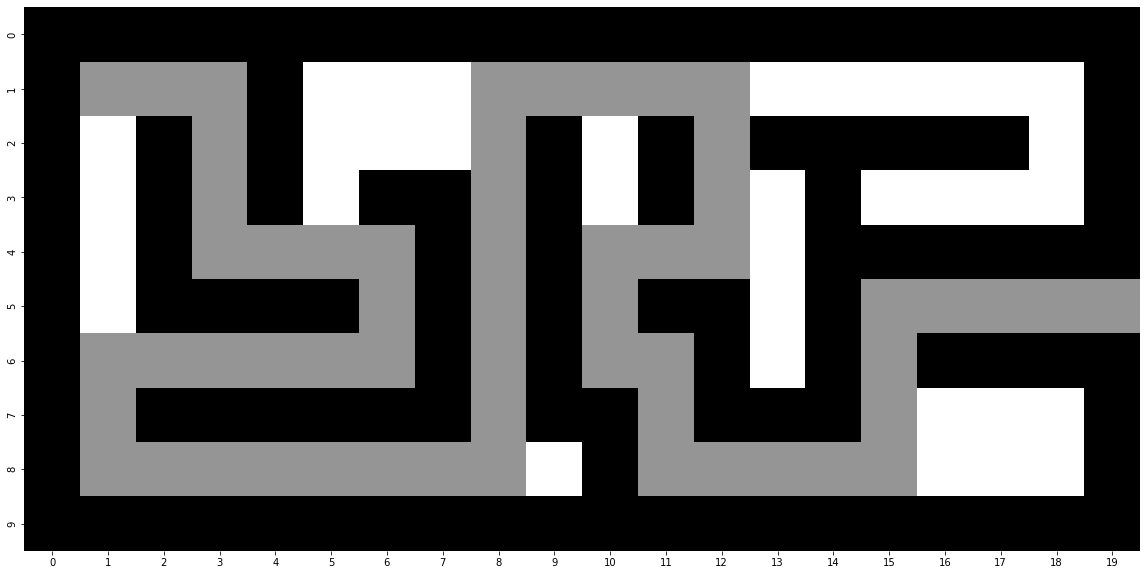

In [18]:
# Define start and goal positions
START = (1,1)
GOAL = (5,19)

# Run the DFS algorithm for path finding
nodesExplored, nodesProcessed = depth_first_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
print("Depth-First-Search (DFS)")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)

**Think about it!**

Is this algorithm *complete*? Is it *optimal*? What can you do to increase its *efficiency*?

The algorithm is not complete. It is not optimal since there is finite depth space with loops.

### Uniform-Cost-Search (UCS)

**Uninformed Search** : Focusses on the graph structure and the *cost from start*, but not the *distance from goal*.

In [21]:
# Uniform-Cost-Search (UCS) with Priority Queue

def uniform_cost_search(mazeGraph, start, goal):
    ''' Function to perform UCS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored or if the new cost is lower 
            if (nextNode not in explored) or (newcost < pathcost[nextNode]):

                # set priority as newcost 
                priority = newcost
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost
    
    return explored, pathcost, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

Uniform-Cost-Search (UCS)

Total nodes in maze : 92
Total nodes visited : 92  |  100.0 %
Final path distance : 35

Path through the Maze : [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (6, 11), (7, 11), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (7, 15), (6, 15), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19)]


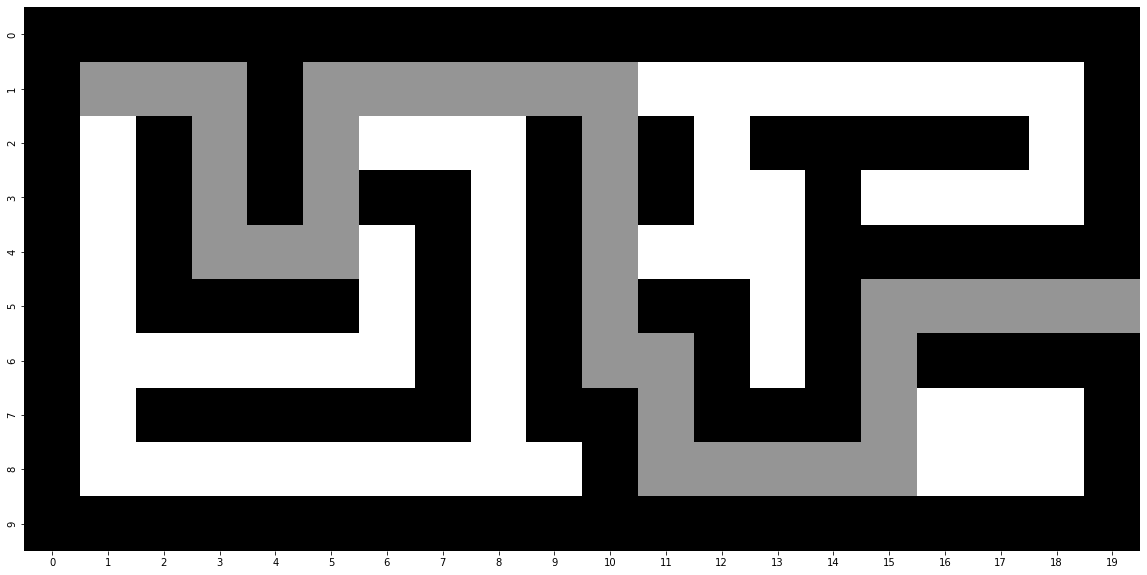

In [22]:
# Define start and goal positions
START = (1,1)
GOAL = (5,19)

# Run the UCS algorithm for path finding
nodesExplored, pathsExplored, nodesProcessed = uniform_cost_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
print("Uniform-Cost-Search (UCS)")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)

**Think about it!**

Is this algorithm *complete*? Is it *optimal*? What can you do to increase its *efficiency*?

The algorithm is complete and optimal. To increase efficiency, we should take into account the distance from the goal and not only the costs from the start

### Greedy-Search (GS)

**Informed Search** : Focusses on the graph structure and the *distance from goal*, but not the *cost from start*.

In [23]:
# This cell has MISSING pieces of code -- fill those in!

# Heuristic function for Distance

def heuristic(nodeA, nodeB):
    (xA, yA) = nodeA
    (xB, yB) = nodeB
    return abs(xA - xB) + abs(yA - yB)


# Greedy-Search (GS) with _??_ Queue

def greedy_search(mazeGraph, start, goal):
    ''' Function to perform GS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.PriorityQueue()      # _Priority_ Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        #get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        #stop when goal is reached
        if currentNode == goal:
            break
        
        for nextNode, weight in mazeGraph.neighbors(currentNode):
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored or if the new cost is lower 
            if (nextNode not in explored) or (newcost < pathcost[nextNode]):

                # set priority as newcost **f(n) = h(n)**
                priority = heuristic(nextNode, goal)
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost
                
        # Write the entire logic for this search algorithm
        # Hint : Take note from the UCS algorithm presented above
    
    return explored, pathcost, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

Greedy-Search (GS)

Total nodes in maze : 92
Total nodes visited : 67  |  72.83 %
Final path distance : 39

Path through the Maze : [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (2, 6), (2, 7), (2, 8), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 12), (3, 12), (4, 12), (4, 11), (4, 10), (5, 10), (6, 10), (6, 11), (7, 11), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (7, 15), (6, 15), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19)]


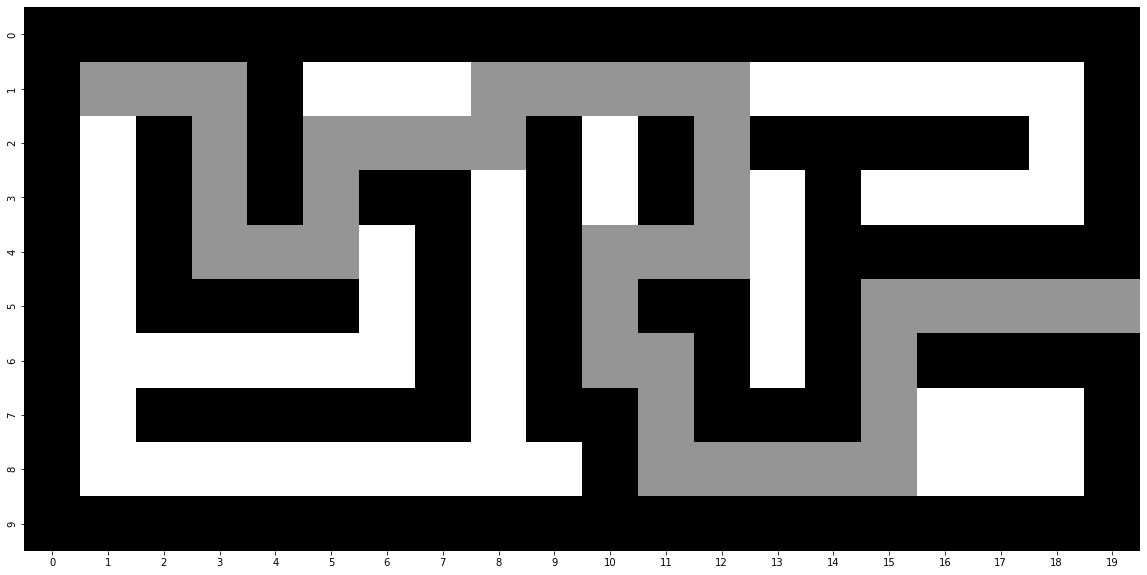

In [24]:
# Define start and goal positions
START = (1,1)
GOAL = (5,19)

# Run the GS algorithm for path finding
nodesExplored, pathsExplored, nodesProcessed = greedy_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
print("Greedy-Search (GS)")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)

**Think about it!**

Is this algorithm *complete*? Is it *optimal*? What can you do to increase its *efficiency*?

The algorithm is not complete nor optimal. To increase efficiency, we should not keep all nodes in its memory.

### A\*-Search (A\*S)

**Informed Search** : Focusses on the graph structure, the *cost from start* and also the *distance from goal*.

In [25]:
# This cell has MISSING pieces of code -- fill those in!

# Heuristic function for Distance

def heuristic(nodeA, nodeB):
    (xA, yA) = nodeA
    (xB, yB) = nodeB
    return abs(xA - xB) + abs(yA - yB)


# A*-Search (A*S) with Priority Queue

def astar_search(mazeGraph, start, goal):
    ''' Function to perform A*S to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # Write the entire logic for this search algorithm
        # Hint : Take note from the UCS algorithm presented above
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored or if the new cost is lower 
            if (nextNode not in explored) or (newcost < pathcost[nextNode]):

                # set priority as newcost **f(n) = g(n) + h(n)**
                priority = newcost + heuristic(nextNode, goal) 
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost

    
    return explored, pathcost, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

A*-Search (A*S)

Total nodes in maze : 92
Total nodes visited : 87  |  94.57 %
Final path distance : 35

Path through the Maze : [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (2, 6), (2, 7), (2, 8), (1, 8), (1, 9), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (6, 11), (7, 11), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (7, 15), (6, 15), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19)]


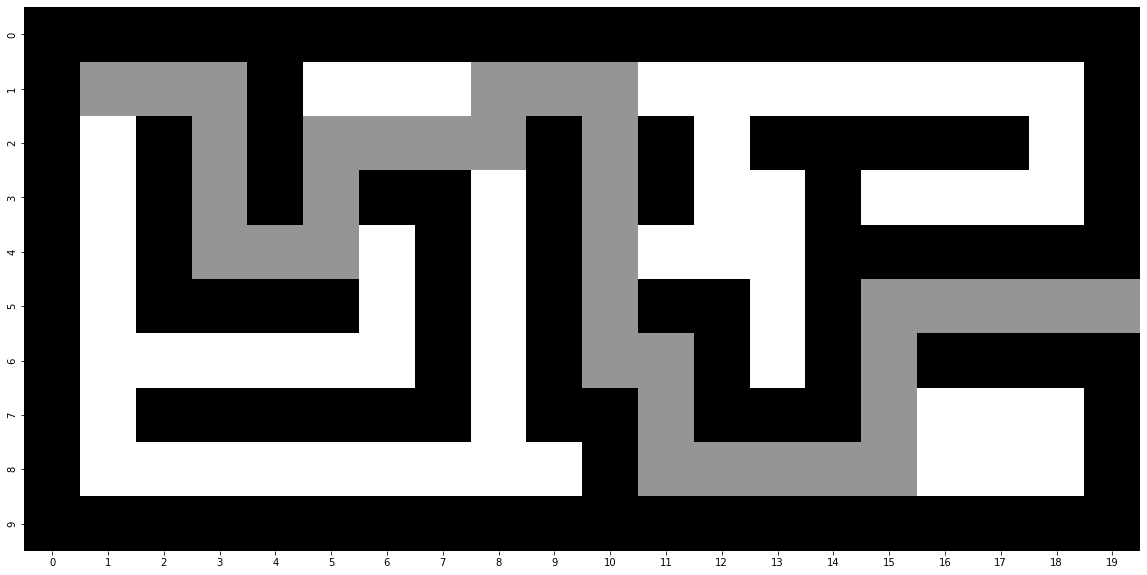

In [26]:
# Define start and goal positions
START = (1,1)
GOAL = (5,19)

# Run the A*S algorithm for path finding
nodesExplored, pathsExplored, nodesProcessed = astar_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
print("A*-Search (A*S)")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)

**Think about it!**

Is this algorithm *complete*? Is it *optimal*? What can you do to increase its *efficiency*?

The algorithm is complete if it is finite depth spaces without loops. This algorithm is optimal depending on the heuristic function that is most suitable should be used.